# Images Folders

In [0]:
# remove previous dirs if is the case
!rm -rdf train
!rm -rdf test

In [0]:
# unzipping test images
!unzip -qq test.zip -d test

In [0]:
# unzipping train images
!unzip -qq train.zip

In [25]:
# checking number of files
!ls -1 test | wc -l
!ls -1 train | wc -l

5361
48896


# Modules

In [4]:
import pandas as pd
import numpy as np
import cv2
import os

# test harness for evaluating models on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


# Functions

In [0]:
# loads images from a folder to a numpy ndarray (!)
def load_images_from_folder(target):
    
    images = []
    fnames = []
    
    for fn in os.listdir(target) :
        
        fnames.append(fn)
    
        fp = target + '/{0}'.format(fn)

        img = cv2.imread(fp, 1)

        images.append(img)
        
    images = np.asarray(images)
    fnames = np.asarray(fnames)
    
    return images, fnames

In [0]:
# loads images from a folder to a numpy ndarray
def load_images_from_fnlist(fnlist, target):
    
    images = []
    
    for fn in fnlist :
    
        fp = target + '/{0}'.format(fn)

        img = cv2.imread(fp, 1)

        images.append(img)
        
    images = np.asarray(images)
    
    return images

In [0]:
# loads images and labels from train truth file (!)
def loads_from_truths(truth_fn='train.truth.csv') :
    
    truths = pd.read_csv(truth_fn)
    
    train_fn = truths.fn.tolist()
    
    labels_unique = truths.label.unique().tolist()
    
    truths['category'] = truths.label.apply( lambda label : labels_unique.index(label) )
    
    train_lb = truths.category
    
    train_img = load_images_from_fnlist( train_fn , 'train' )
    
    return train_img, train_lb

In [0]:
# loads images and labels from train truth file splitting into train and test
def loads_from_truths_both(index, truth_fn='train.truth.csv') :
    
    truths = pd.read_csv(truth_fn)
    
    train_fn = truths.fn.tolist()
    
    labels_unique = truths.label.unique().tolist()
    
    labeler = lambda label : labels_unique.index(label)
    
    truths['category'] = truths.label.apply( labeler )
    
    train_lb = truths.category
    
    train_img = load_images_from_fnlist( train_fn , 'train' )
    
    train_set = ( train_img[:index], train_lb[:index] )
    
    test_set = ( train_img[index:], train_lb[index:] )
    
    return train_set, test_set

In [0]:
# load train and test dataset
def load_dataset():

    # load dataset
    (trainX, trainY), (testX, testY) = loads_from_truths_both(40000)

    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)

    return trainX, trainY, testX, testY

In [0]:
# scale pixels
def prep_pixels(train, test):

    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')

    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0

    # return normalized images
    return train_norm, test_norm

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):

    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')

    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')

    pyplot.show()

    # save plot to file
    # filename = sys.argv[0].split('/')[-1]
    # pyplot.savefig(filename + '_plot.png')

    pyplot.close()

In [0]:
# run the test harness for evaluating a model
def run_test_harness(model, epochs=100, piece=5000):
    
    # load dataset
    trainX, trainY, testX, testY = load_dataset()

    # slicing the dataset
    trainX, trainY, testX, testY = trainX[:piece], trainY[:piece], testX[:piece], testY[:piece]

    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)

    # fit model
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=64, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)

    print('> %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)

# Models

In [0]:
def model1():

	model = Sequential()

	# 3-block vgg style architecture
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))

	# example output part of the model
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(4, activation='softmax'))

	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model

In [0]:
# a model with dropout layers

def model2():

	model = Sequential()

	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))

	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))

	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))

	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(4, activation='softmax'))

	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model

# Trainning

> 41.400


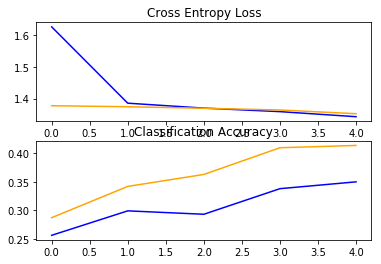

CPU times: user 12.3 s, sys: 3.05 s, total: 15.4 s
Wall time: 16.6 s


In [65]:
%%time 

run_test_harness( model2(), epochs=5, piece=1000 )

> 91.153


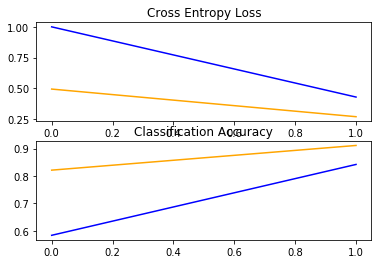

CPU times: user 48.9 s, sys: 16.2 s, total: 1min 5s
Wall time: 1min 18s


In [67]:
%%time 

model = model2()

run_test_harness( model, epochs=2, piece=50000 )

> 97.280


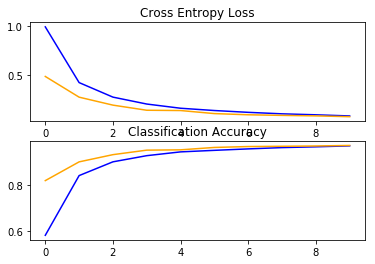

CPU times: user 3min 13s, sys: 1min 4s, total: 4min 17s
Wall time: 5min 26s


In [70]:
%%time 

model = model2()

run_test_harness( model, epochs=10, piece=50000 )

# Predicting

In [72]:
model